In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Search for the pollen image file among possible extensions
candidates = ['pollen.tif', 'pollen.tiff']
file_path = next((p for p in candidates if os.path.exists(p)), None)
if file_path is None:
    raise FileNotFoundError(f"Pollen image not found in paths: {candidates}")


In [5]:
# Load the original image in grayscale
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

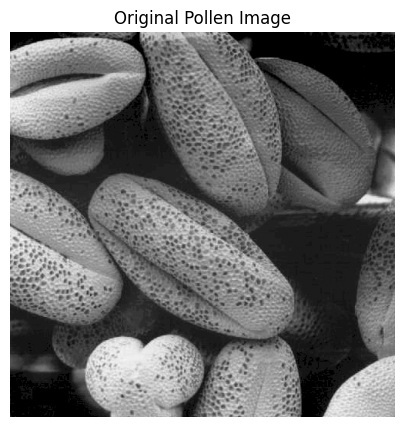

In [6]:
# Display the original grayscale image
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.title('Original Pollen Image')
plt.axis('off')
plt.show()

In [7]:
# Statistical analysis of pixel intensities
# Compute histogram, mean, and standard deviation
hist, bins = np.histogram(img.ravel(), bins=256, range=(0, 255))
mean_int = img.mean()
std_int = img.std()
print(f'Mean intensity: {mean_int:.2f}, Standard deviation: {std_int:.2f}')

Mean intensity: 109.08, Standard deviation: 11.49


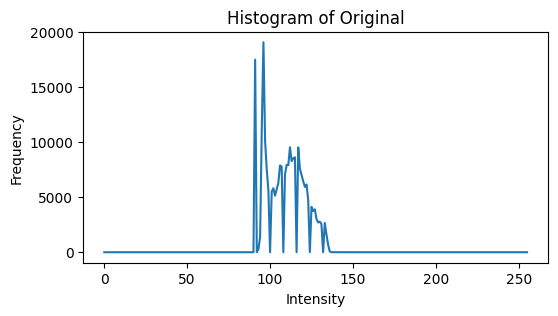

In [8]:
# Plot the histogram of the original image
plt.figure(figsize=(6, 3))
plt.plot(hist)
plt.title('Histogram of Original')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Approach 1: Homomorphic filtering
# Filter parameters
gamma1, gamma2 = 0.5, 2.0   # low and high frequency gain
c_hom, D0 = 1.0, 30.0       # scaling constant and cutoff frequency

In [10]:
# 1. Log-transform the image to separate illumination and reflectance
img_log = np.log1p(img.astype(np.float32))

# 2. Create the homomorphic filter in the frequency domain
M, N = img.shape
y, x = np.indices((M, N))
center = (M / 2, N / 2)
D = np.sqrt((y - center[0])**2 + (x - center[1])**2)
H = (gamma2 - gamma1) * (1 - np.exp(-c_hom * (D**2) / (D0**2))) + gamma1

# 3. Apply filter: FFT → shift → multiply by H → inverse shift → inverse FFT
F = np.fft.fft2(img_log)
F_shift = np.fft.fftshift(F)
G_shift = H * F_shift
G = np.fft.ifftshift(G_shift)
img_hom = np.fft.ifft2(G)
img_hom = np.real(img_hom)

# 4. Exponential to undo log-transform, then clip to [0,255]
img_hom = np.expm1(img_hom)
img_hom = np.clip(img_hom, 0, 255).astype(np.uint8)


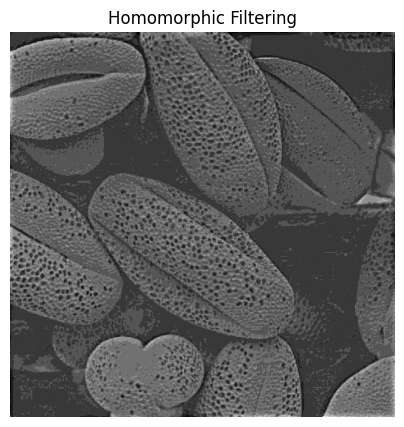

In [11]:
# Display the homomorphic-filtered result
plt.figure(figsize=(5, 5))
plt.imshow(img_hom, cmap='gray')
plt.title('Homomorphic Filtering')
plt.axis('off')
plt.show()

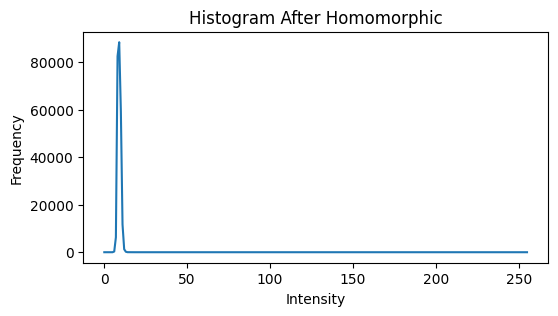

In [12]:
# Plot histogram of the homomorphic result
hist_hom, _ = np.histogram(img_hom.ravel(), bins=256, range=(0, 255))
plt.figure(figsize=(6, 3))
plt.plot(hist_hom)
plt.title('Histogram After Homomorphic')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Approach 2: Morphological Top-hat + Contrast Stretching
# 1. Estimate background via morphological opening with a large structuring element
kernel_size = 51  # size of the structuring element
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
background = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

In [14]:
# 2. Compute the Top-hat transform (original minus background)
top_hat = cv2.subtract(img, background)

# 3. Stretch contrast of the Top-hat result to the full 0–255 range
contrast_stretch = cv2.normalize(
    top_hat, None,
    alpha=0, beta=255,
    norm_type=cv2.NORM_MINMAX
)

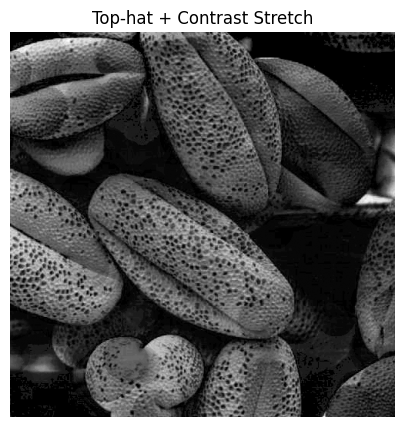

In [15]:
# Display the Top-hat + contrast-stretched result
plt.figure(figsize=(5, 5))
plt.imshow(contrast_stretch, cmap='gray')
plt.title('Top-hat + Contrast Stretch')
plt.axis('off')
plt.show()

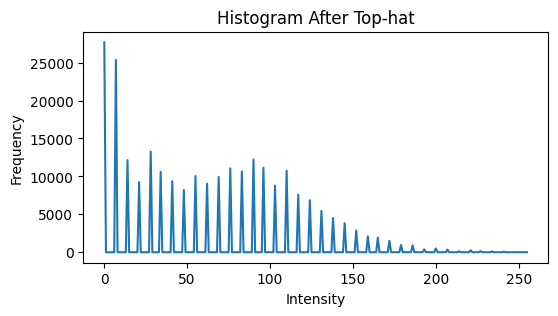

In [16]:
# Plot histogram of the Top-hat result
hist_th, _ = np.histogram(contrast_stretch.ravel(), bins=256, range=(0, 255))
plt.figure(figsize=(6, 3))
plt.plot(hist_th)
plt.title('Histogram After Top-hat')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()